## Load modules

In [1]:
import xarray as xr
import numpy as np
import cdo
import copy
import matplotlib.pyplot as plt

## Initialisation cdo

In [2]:
cdo = cdo.Cdo()

## Declare paths

In [1]:
inputpath_raw = '/data/cburgard/MELT_PARAM_NONRESOLVED/raw/'
inputpath_interim = '/data/cburgard/MELT_PARAM_NONRESOLVED/interim/'
inputpath_NEMO = '/data/cburgard/PREPARE_FORCING/PREPARE_CAVITY_MASKS/raw/eORCA1.4.3_OpenSeas_OpenAllCav_ModStraights/'
inputpath_NEMO_interim = '/data/cburgard/PREPARE_FORCING/PREPARE_CAVITY_MASKS/interim/'

## Define grids

In [36]:
## source grid
fELMER_grid='../ant50.gl1-ismip6_grid.nc'
ds_elmer_grid=xr.open_dataset(fELMER_grid)

## target grid
fNEMO_grid = 'grid_O2_NEMO4.2_CDO.nc'
ds_nemo_grid=xr.open_dataset(fNEMO_grid)

## Inputs files

In [37]:
# Elmer state data
ds_elmer=xr.open_dataset('../ismip6_states_NEMO-ELMER-iann-eO1-2EIS-ICB-ISF3-antarctica_001.nc')

# NEMO bedrock data
ds_nemo=xr.open_dataset('domain_cfg_O2.nc')

# compute area not resolved by NEMO
**Method:**
- conservative interpolation of Elmer floating cell to NEMO
- set to 1 value between 0 and 1 (ie area to parametrised in NEMO)
- conservative interpolation back to ELMER to give the cell that need to be included in the param and the area scale factor

In [38]:
# create clean data_set array (cdo is very sensitive)
ds_elmer_sftflf = xr.Dataset(
    data_vars=dict(
        sftflf=(["time","ncells"], ds_elmer.sftflf.values),
        time_instant=(["time"],ds_elmer.time_instant.values),
        lon_bnds=(["ncells","vertices"], ds_elmer_grid.lon_bnds.values),
        lat_bnds=(["ncells","vertices"], ds_elmer_grid.lat_bnds.values),
        time_instant_bnds=(["time","axis_nbounds"],ds_elmer.time_instant_bounds.values),
    ),
    coords=dict(
        lon=(["ncells"],ds_elmer_grid.lon.values,ds_elmer_grid.lon.attrs),
        lat=(["ncells"],ds_elmer_grid.lat.values,ds_elmer_grid.lat.attrs),
    ),
)

In [ ]:
## CDO inperpolation
### cdo.remapcon(f'{target_grid}',input=input_xrdataset, returnArray=variable_name_to_process)
#NEMO_sftflf=cdo.remapcon(f'{fNEMO_grid}', input=ds_elmer_sftflf, returnArray='sftflf', env={"CDO_REMAP_NORM": "areafrac"}).squeeze()
#NEMO_sftflf[0,50:60]=1 # => specific to ORCA2

In [ ]:
# set to 1 cell to parametrised
#NEMO_cell_to_param=np.zeros(shape=NEMO_sftflf.shape)
#NEMO_cell_to_param=np.where((NEMO_sftflf > 0) & (NEMO_sftflf<=1),1,0)

## Read NEMO geometry and ELMER data

In [61]:
# Read domain_cfg.nc
ds_nemo_domain=xr.open_dataset('domain_cfg_O2.nc')
NEMO_isfd=ds_nemo_domain.top_level.squeeze()

# get NEMO mask
NEMO_mask=ds_nemo_domain.bottom_level.squeeze()
NEMO_mask=np.where(NEMO_mask>0,1,0)
NEMO_mask[30::,:]=1 # => specific to ORCA2

# interpolation back to Elmer to retreive the area scale factor
ds_nemo_param=copy.deepcopy(ds_nemo_grid).rename_vars({'dummy': 'cell_to_param'})
ds_nemo_param['cell_to_param'].values=NEMO_cell_to_param.squeeze()

## CDO inperpolation
ELMER_cell_to_param_sf=ds_elmer.sftflf.values.squeeze()

## Define the cell where to activate the param in NEMO

Maybe this need to be done before the reinterpolation back to ELMER and the draft distribution.
 * compute list of basin from the NEMO_mask_param_basins variables
 * mask the missing basin in the NEMO_basins variable
 * do a nn extrapolation on the NEMO grid
 * interpolate back to ELMER
 * compute the isf draft distribution

In [59]:
# Define NEMO coastal mask of the area to parametrised
def get_coastal_msk(mask_in,lewp):
    nj_out=mask_in.shape[0]
    ni_out=mask_in.shape[1]

    if lewp:
        mask=np.zeros(shape=(nj_out,ni_out+2))
        mask[:,1:-1]=mask_in
        mask[:, 0]=mask[:,-2]
        mask[:,-1]=mask[:, 1]
        xslc=slice(0,ni_out)
    else:
        mask=mask_in
        xslc=slice(1,-1)
        
    mask_coast=np.zeros(shape=(nj_out,ni_out))
    mask_coast[1:-1,xslc]= ( mask[1:-1,1:-1] + 
                             mask[0:-2,1:-1] + mask[2::,1:-1] + mask[1:-1,0:-2] + mask[1:-1,2::] +
                             mask[0:-2,0:-2] + mask[2::,2::]  + mask[2::,0:-2]  + mask[0:-2,2::] ) * mask[1:-1,1:-1]
    mask_coast[(mask_coast > 1) & (mask_coast < 9)] = 10
    mask_coast[mask_coast!=10]=np.nan
    mask_coast=mask_coast.astype(np.float32)
    mask_coast[mask_coast==10]=1
    
    return mask_coast

In [66]:
# get coastal cell along area to parametrized
# method:
# - reverse the cell_to_param mask
# - detect contour
# - pick from contour only the ocean points
NEMO_mask_param_basins=-np.zeros(shape=NEMO_cell_to_param.shape)
#NEMO_mask_param_basins=np.where(NEMO_cell_to_param>0,0,1)
NEMO_mask_param_basins=get_coastal_msk(NEMO_mask,True)
NEMO_mask_param_basins[np.isnan(NEMO_mask_param_basins) | (NEMO_mask==0)]=-1



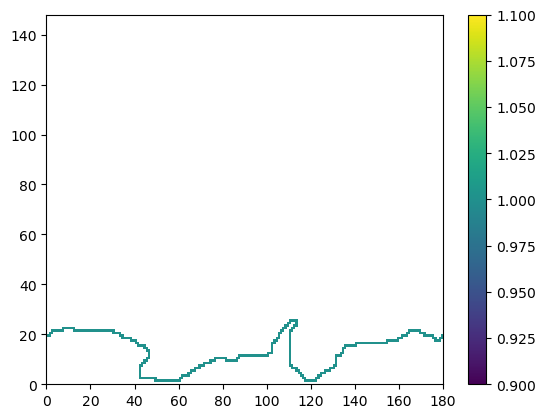

In [64]:
plt.pcolormesh(get_coastal_msk(NEMO_mask,True))
plt.colorbar()

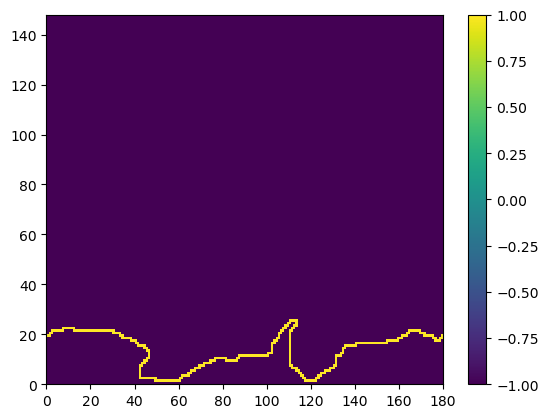

In [68]:
plt.pcolormesh(NEMO_mask_param_basins)
plt.colorbar()

# Manage basins
## Interpolation of basin variable from Elmer to NEMO grid
**Method:** cdo nearest neighbourg

**Warning** : 
 * possibly this need to be move after the domain cfg computation
 * why not use the extrapolate basin file on stereo ?

In [46]:
## Read basin file at 2km
ds_ANT_basins=xr.open_dataset('../basins_for_param_v5_raster_extrapolate_nco.nc')

## CDO inperpolation
NEMO_basins=cdo.remapnn(f'{fNEMO_grid}',input=ds_ANT_basins, returnArray='Band1').squeeze()

/Users/mathiotp/anaconda3/lib/python3.11/site-packages/xarray/coding/variables.py:241: RuntimeWarning: invalid value encountered in cast
  encoding["_FillValue"] = dtype.type(fv)


## Get all the basins id mask along the 'coastal' band

In [ ]:
# get basin number for each coastal cell
NEMO_mask_param_basins=np.where((NEMO_mask_param_basins >= 0), NEMO_basins, -1)

In [78]:
# get list of ID avalable in NEMO along the 'coastal' band
NEMO_basins_list = np.unique(NEMO_mask_param_basins[NEMO_mask_param_basins >= 0]).astype(int)
ANT_basins_list = np.unique(ds_ANT_basins.Band1).astype(int)

## Interpolation back to Elmer from NEMO grid
**Why:** We need to do this in case some small basins have been removed during the nn interpolation to NEMO. Without this step, there is possibility that the sum of the area distribution seen by NEMO do not match the total area to parametrised in ELMER.  

In [79]:
# Define the new basin mask based on the list of available basins
## Mask all id not present in the list in the original basin file
ANT_basins_corr=ds_ANT_basins.Band1.copy()
for basin in set(ANT_basins_list) - set(NEMO_basins_list):
    ANT_basins_corr.values[ANT_basins_corr.values == basin] = np.nan


In [80]:

## Extrapolate the fill the corrected id mask
from scipy.interpolate import NearestNDInterpolator
data = ANT_basins_corr.values
mask=np.where(~np.isnan(data))
interp = NearestNDInterpolator(np.transpose(mask), data[mask])
ANT_basins_corr.values = interp(*np.indices(data.shape))


In [81]:
## Interpolate the correct mask to Elmer
ELMER_basins=cdo.remapnn(f'{fELMER_grid}',input=ANT_basins_corr, returnArray='Band1')

/Users/mathiotp/anaconda3/lib/python3.11/site-packages/xarray/coding/variables.py:241: RuntimeWarning: invalid value encountered in cast
  encoding["_FillValue"] = dtype.type(fv)


# Interpolation back from NEMO to ELMER to retreive the area scale factor

## Compute depth distribution

In [82]:
# get elmer element area, ice shelf draft and floating cell mask
isfd=ds_elmer.base.values.squeeze()
mask_isf=ds_elmer.sftflf.values.squeeze()
cell_area=np.float64(ds_elmer.cell_area.values.squeeze())

# get NEMO depth range
e3t=ds_nemo_domain.e3t_1d.values.squeeze()

**WARNING** : the basin list below need to match the list of basin in NEMO. Not sure it works in case some basins do not extrapolate far enough (nn approach issue)

In [83]:
# compute weight for histogram
# As there is no melt in Elmer on the partially grounded element, these element should be excluded
ELMER_cell_to_param_sf[np.isnan(ELMER_cell_to_param_sf) | (mask_isf < 1)]=0.0
weight=np.float64(cell_area)*np.float64(ELMER_cell_to_param_sf)
ELMER_isfd=isfd*mask_isf

# define histogram bin
binbnds=np.zeros(shape=(e3t.shape[0]+1,))
binbnds[1::]=np.cumsum(e3t[:])

# retreive basin list id
basin_list=set(ELMER_basins.flatten())

# compute historgram for each basin
hist_isfd=np.zeros(shape=(len(basin_list),len(e3t)))
for ib, ibasin in enumerate(basin_list):
    hist_isfd[ib,:],_=np.histogram(-ELMER_isfd[ELMER_basins==ibasin],binbnds,weights=weight[ELMER_basins==ibasin])
    print(ib, ibasin, weight[ELMER_basins==ibasin].sum(), hist_isfd[ib,:].sum(), weight[ELMER_basins==ibasin].sum()-hist_isfd[ib,:].sum(), max(-ELMER_isfd[ELMER_basins==ibasin]), min(-ELMER_isfd[ELMER_basins==ibasin]))

0 0 899657157.03125 899657157.03125 0.0 950.6444 0.0
1 3 35532241333.328125 35532241333.328125 0.0 1025.0945 0.0
2 4 40949599100.296875 40949599100.296875 0.0 1020.0381 0.0
3 5 6258080091.09375 6258080091.09375 0.0 1008.47675 0.0
4 6 1558816772.046875 1558816772.046875 0.0 605.60376 0.0
5 8 1951891844.46875 1951891844.46875 0.0 624.6696 0.0
6 10 9741761354.3125 9741761354.3125 0.0 1111.6478 0.0
7 11 38786365232.53125 38786365232.53125 0.0 1220.616 0.0
8 13 5974837801.875 5974837801.875 0.0 591.7915 0.0
9 14 1987578726.96875 1987578726.96875 0.0 611.6769 0.0
10 16 21130662584.03125 21130662584.03125 0.0 874.4691 0.0
11 17 8561894337.375 8561894337.375 0.0 513.515 0.0
12 18 32380336275.65625 32380336275.65625 0.0 713.9531 0.0
13 21 4453085203.34375 4453085203.34375 0.0 622.096 0.0
14 23 83553552.28125 83553552.28125 0.0 542.4724 -0.0
15 24 24837946.78125 24837946.78125 0.0 399.90945 -0.0
16 25 278499789.6875 278499789.6875 0.0 1035.7677 0.0
17 26 51448635801.78125 51448635801.78125 0.0 2

In [95]:
zmin_basin = {}
zmax_basin = {}

for ibasin in basin_list:
    # Select the cells in the current basin
    mask = (ELMER_basins == ibasin)
    valid_draft = -ELMER_isfd[mask]  # Make draft positive down
    valid_weight = weight[mask]

    # Filter out zero-weight or nan values
    valid = (valid_weight > 0) & np.isfinite(valid_draft)
    if np.any(valid):
        # Use weighted percentile function (approximation via repeat)
        sample_depths = np.repeat(valid_draft[valid], np.maximum(valid_weight[valid]/np.min(valid_weight[valid]),1).astype(int))
        zmin = np.percentile(sample_depths, 1)
        zmax = np.percentile(sample_depths, 99)
    else:
        zmin = np.nan
        zmax = np.nan

    zmin_basin[ibasin] = zmin
    zmax_basin[ibasin] = zmax


In [96]:
zmin_map = np.full_like(NEMO_mask_param_basins, 0, dtype=np.float64)
zmax_map = np.full_like(NEMO_mask_param_basins, 0, dtype=np.float64)

for ibasin in basin_list:
    zmin_map[NEMO_mask_param_basins == ibasin] = zmin_basin[ibasin]
    zmax_map[NEMO_mask_param_basins == ibasin] = zmax_basin[ibasin]

## Define the output file

In [97]:
# for Nico's version:
# Étape 1 : Extraire les ID uniques triés (en ignorant les valeurs invalides éventuelles comme -1)
unique_ids = np.sort(np.unique(NEMO_mask_param_basins[NEMO_mask_param_basins >= 0]))

# Étape 2 : Créer un dictionnaire de remapping avec un décalage de +1
id_map = {orig_id: new_id for new_id, orig_id in enumerate(unique_ids, start=1)}

# Étape 3 : Appliquer le remapping
NEMO_mask_param_basins_remapped = np.full_like(NEMO_mask_param_basins, fill_value=0, dtype=np.int32)  # 0 pour "non défini"
for orig_id, new_id in id_map.items():
    NEMO_mask_param_basins_remapped[NEMO_mask_param_basins == orig_id] = new_id

# Étape 4 : Nouvelle liste de basins consécutifs à partir de 1
basin_list_remapped = np.arange(1, len(unique_ids) + 1, dtype=np.int32)

In [98]:
# Compute global min/max for each variable
zmin_global_min = float(np.nanmin(zmin_map))
zmin_global_max = float(np.nanmax(zmin_map))
zmax_global_min = float(np.nanmin(zmax_map))
zmax_global_max = float(np.nanmax(zmax_map))

area_dist_min = float(np.nanmin(hist_isfd))
area_dist_max = float(np.nanmax(hist_isfd))

param_id_min = int(np.nanmin(NEMO_mask_param_basins_remapped))
param_id_max = int(np.nanmax(NEMO_mask_param_basins_remapped))

# Create dataset for output
ds_out = xr.Dataset(
    data_vars=dict(
        isf_param_id=(["x", "y"], NEMO_mask_param_basins_remapped.astype(np.int32), dict(
            units='1',
            long_name='ice shelf parameterization basin ID',
            valid_min=param_id_min,
            valid_max=param_id_max
        )),
        
        isf_area_dist=(["z", "id"], hist_isfd.T, dict(
            units='m2',
            long_name='ice shelf draft area distribution per depth bin',
            valid_min=area_dist_min,
            valid_max=area_dist_max
        )),
        
        isf_zmin=(["x", "y"], zmin_map, dict(
            units='m',
            long_name='ice shelf minimum draft depth (10th percentile)',
            valid_min=zmin_global_min,
            valid_max=zmin_global_max
        )),
        
        isf_zmax=(["x", "y"], zmax_map, dict(
            units='m',
            long_name='ice shelf maximum draft depth (90th percentile)',
            valid_min=zmax_global_min,
            valid_max=zmax_global_max
        )),
    ),
    
    coords=dict(
        lon=(["x", "y"], ds_nemo_domain.glamt.values.squeeze(), dict(
            units='degrees_east',
            long_name='longitude'
        )),
        lat=(["x", "y"], ds_nemo_domain.gphit.values.squeeze(), dict(
            units='degrees_north',
            long_name='latitude'
        )),
        bin_width=(["z"], e3t, dict(
            units='m',
            long_name='vertical bin thickness'
        )),
        basin=(["id"], np.array(list(basin_list_remapped)).astype(np.int32), dict(
            long_name='list of unique basin IDs'
        )),
    ),
)

# Save to NetCDF
ds_out.to_netcdf('isf_param.nc')


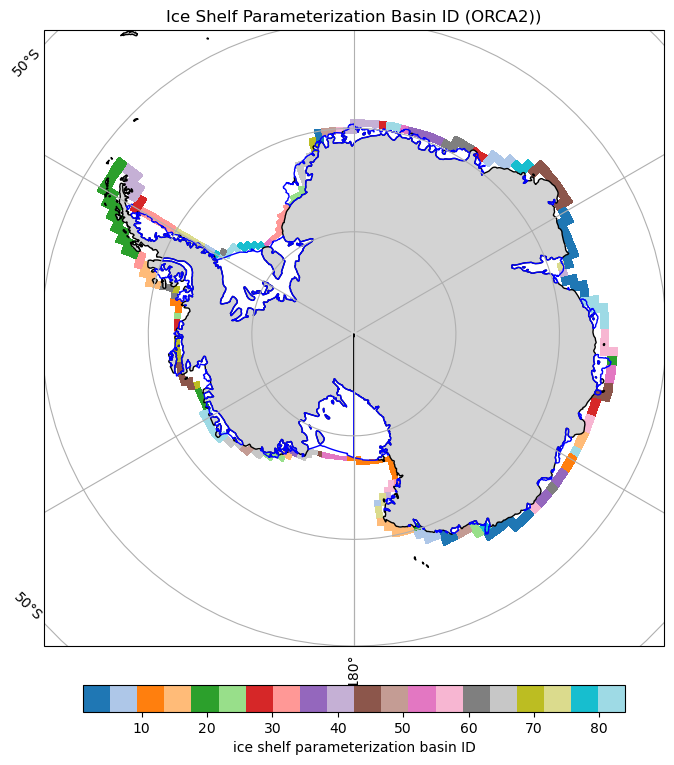

In [13]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Load your dataset
ds = xr.open_dataset('isf_param.nc')

# Extract data
param_id = ds['isf_param_id']
lon = ds['lon']
lat = ds['lat']

# Identifier les ID valides (1 à 84)
valid_ids = np.arange(1, 85)

# Créer une permutation aléatoire des ID
shuffled_ids = np.random.permutation(valid_ids)

# Construire un dictionnaire de remappage
remap_dict = dict(zip(valid_ids, shuffled_ids))

# Appliquer le remappage sur une copie
param_id_shuffled = np.full_like(param_id, fill_value=-1)
for old_id, new_id in remap_dict.items():
    param_id_shuffled[param_id == old_id] = new_id


# Mask bad values (-1)
param_id_masked = np.ma.masked_where(param_id.values == 0, param_id_shuffled)

# Set up projection
proj = ccrs.SouthPolarStereo()  # EPSG:3031

# Create figure and axis
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=proj)
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# Add land and ice shelves using Natural Earth features
land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='black', facecolor='lightgray')
ice_shelves = cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_polys', '50m',
                                           edgecolor='blue', facecolor='none')

ax.add_feature(land, zorder=1)
ax.add_feature(ice_shelves, zorder=2)

# Plot the param_id map
c = ax.pcolormesh(lon, lat, param_id_masked,
                  transform=ccrs.PlateCarree(),
                  cmap='tab20', shading='auto', zorder=0)

# Add colorbar
cb = plt.colorbar(c, ax=ax, orientation='horizontal', pad=0.05, shrink=0.7)
cb.set_label(param_id.long_name)

# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

plt.title('Ice Shelf Parameterization Basin ID (ORCA2))')
#plt.tight_layout()
#
fig.savefig('basin_id_map.png', dpi=150, bbox_inches='tight', transparent=False)